In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
train_data = pd.read_csv('dataset\\train.csv')
test_data = pd.read_csv('dataset\\test.csv')

print(len(train_data), len(test_data))
train_data.head()

891 418


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 打乱训练集

In [3]:
train_data = train_data.sample(frac=1)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
568,569,0,3,"Doharr, Mr. Tannous",male,NaN,0,0,2686,7.2292,NaN,C
35,36,0,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,113789,52.0000,NaN,S
211,212,1,2,"Cameron, Miss. Clear Annie",female,35.0,0,0,F.C.C. 13528,21.0000,NaN,S
346,347,1,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S


# 总体数据缺省
## 合并起来对缺省数据填充或删除

<table><thead><tr><th>变量</th><th>定义</th><th>键值</th></tr></thead><tbody><tr><td>survival</td><td>存活</td><td>0=No,1=Yes</td></tr><tr><td>pclass</td><td>票的类别</td><td>1=1st,2=2nd,3=3rd</td></tr><tr><td>sex</td><td>性别</td><td></td></tr><tr><td>Age</td><td>年龄</td><td></td></tr><tr><td>sibsp</td><td>在船上有几个兄弟/配偶</td><td></td></tr><tr><td>parch</td><td>在船上有几个双亲/孩子</td><td></td></tr><tr><td>ticket</td><td>票编号</td><td></td></tr><tr><td>fare</td><td>乘客票价</td><td></td></tr><tr><td>cabin</td><td>客舱号码</td><td></td></tr><tr><td>embarked</td><td>登船港口</td><td>C = Cherbourg, Q = Queenstown, S = Southampton</td></tr></tbody></table>

In [4]:
all_data=pd.concat([train_data,test_data],ignore_index=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## 处理数据

In [5]:
# 对缺省的年龄进行平均数填充
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].mean())
# 对缺省的登船港口进行众数填充
all_data['Embarked'] = all_data['Embarked'].fillna(all_data['Embarked'].mode())
# 性别转换为1和0
all_data['Sex']=[1 if x=='male' else 0 for x in all_data.Sex]
# 将SibSp,Parch 用有无代替数量以减少离散
all_data['SibSp']=[0 if x==0 else 1 for x in all_data.Sex]
all_data['Parch']=[0 if x==0 else 1 for x in all_data.Sex]
# 丢失票价用同等票类型的平均数进行填充
all_data['Fare'] = all_data['Fare'].fillna(all_data.pivot_table(index='Pclass', values='Fare', aggfunc=np.mean).loc[all_data[all_data['Fare'].isnull()]['Pclass'],'Fare'])
# 将上船码头与票价以独热编码鵆
all_data['p1']=np.array(all_data['Pclass']==1).astype(np.int32)
all_data['p2']=np.array(all_data['Pclass']==2).astype(np.int32)
all_data['p3']=np.array(all_data['Pclass']==3).astype(np.int32)
all_data['e1']=np.array(all_data['Embarked']=='S').astype(np.int32)
all_data['e2']=np.array(all_data['Embarked']=='C').astype(np.int32)
all_data['e3']=np.array(all_data['Embarked']=='Q').astype(np.int32)
#对票价和年龄归一化
all_data['Age'] = (all_data['Age']-all_data['Age'].min())/(all_data['Age'].max()-all_data['Age'].min())
all_data['Fare'] = (all_data['Fare']-all_data['Fare'].min())/(all_data['Fare'].max()-all_data['Fare'].min())

## 数据选取

In [6]:
all_data_selected = all_data[['p1', 'p2', 'p3', 'e1', 'e2', 'e3', 'Sex', 'Fare', 'Age']].values#, 'SibSp', 'Parch'
train_data = all_data_selected[:len(train_data)]
test_data = all_data_selected[len(train_data):]
train_label1 = all_data[['Survived']].values
train_lable = train_label1[:len(train_data)].reshape(-1,1)

train_data[0:5,:]

array([[0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.02052723, 0.27345609],
       [0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.01411046, 0.3721801 ],
       [1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.10149724, 0.52398848],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.04098927, 0.43630214],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.02537431, 0.49893524]])

In [7]:
train_x = tf.cast(train_data, tf.float32)
train_y = tf.cast(train_lable, tf.int16)
test_x = tf.cast(test_data, tf.float32)
print(train_x.shape, train_y.shape)

(891, 9) (891, 1)


## 模型配置与训练

In [8]:
model=tf.keras.Sequential()
try:
    model = tf.keras.models.load_model("Titanic.h5")
    model.summary()
except:
    model.add(tf.keras.layers.Dense(16,activation="relu",kernel_regularizer = tf.keras.regularizers.l2()))#input_shape=(1,9)添加隐含层，隐含层是全连接层，128个结点,激活函数使用relu函数
    model.add(tf.keras.layers.Dense(8,activation="relu"))
    model.add(tf.keras.layers.Dense(1,activation="sigmoid"))#添加输出层，输出层使全连接层，激活函数是sigmoid函数
    
    #配置训练方法
    #优化器使用adam,损失函数使用二值交叉熵损失函数，准确率使用稀疏分类准确率函二值
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.07),
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])
    
    # #训练模型
    # #使用训练集中的数据训练，从中划分20%作为测试数据,用在每轮训练后评估模型的性能，每个小批量使用32条数据，训练50轮
    history = model.fit(train_x,train_y,
                batch_size=32,
                epochs=60,
                validation_split=0.2)
    model.summary()
    model.save("Titanic.h5", overwrite=True, save_format=None)

Epoch 1/60
23/23 [==============================] - 2s 46ms/step - loss: 0.6572 - binary_accuracy: 0.6516 - val_loss: 0.5127 - val_binary_accuracy: 0.8045
Epoch 2/60
23/23 [==============================] - 0s 7ms/step - loss: 0.5755 - binary_accuracy: 0.7653 - val_loss: 0.5096 - val_binary_accuracy: 0.8101
Epoch 3/60
23/23 [==============================] - 0s 6ms/step - loss: 0.5329 - binary_accuracy: 0.7950 - val_loss: 0.4760 - val_binary_accuracy: 0.8101
Epoch 4/60
23/23 [==============================] - 0s 7ms/step - loss: 0.4905 - binary_accuracy: 0.7873 - val_loss: 0.5239 - val_binary_accuracy: 0.8045
Epoch 5/60
23/23 [==============================] - 0s 7ms/step - loss: 0.4977 - binary_accuracy: 0.8053 - val_loss: 0.4804 - val_binary_accuracy: 0.8101
Epoch 6/60
23/23 [==============================] - 0s 7ms/step - loss: 0.4874 - binary_accuracy: 0.8013 - val_loss: 0.4880 - val_binary_accuracy: 0.8045
Epoch 7/60
23/23 [==============================] - 0s 6ms/step - loss: 0.4

Epoch 54/60
23/23 [==============================] - 0s 6ms/step - loss: 0.5196 - binary_accuracy: 0.7652 - val_loss: 0.4999 - val_binary_accuracy: 0.7877
Epoch 55/60
23/23 [==============================] - 0s 6ms/step - loss: 0.5786 - binary_accuracy: 0.7633 - val_loss: 0.5107 - val_binary_accuracy: 0.7877
Epoch 56/60
23/23 [==============================] - 0s 6ms/step - loss: 0.5229 - binary_accuracy: 0.7721 - val_loss: 0.4679 - val_binary_accuracy: 0.8156
Epoch 57/60
23/23 [==============================] - 0s 6ms/step - loss: 0.4780 - binary_accuracy: 0.8111 - val_loss: 0.5396 - val_binary_accuracy: 0.7709
Epoch 58/60
23/23 [==============================] - 0s 6ms/step - loss: 0.4708 - binary_accuracy: 0.7908 - val_loss: 0.4791 - val_binary_accuracy: 0.8101
Epoch 59/60
23/23 [==============================] - 0s 6ms/step - loss: 0.4723 - binary_accuracy: 0.7982 - val_loss: 0.4669 - val_binary_accuracy: 0.7933
Epoch 60/60
23/23 [==============================] - 0s 6ms/step - los

In [9]:
model.evaluate(train_x,train_y)

28/28 [==============================] - 0s 3ms/step - loss: 0.4559 - binary_accuracy: 0.8092


[0.45588964223861694, 0.8092031478881836]

## 可视化

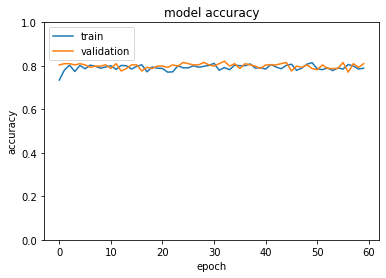

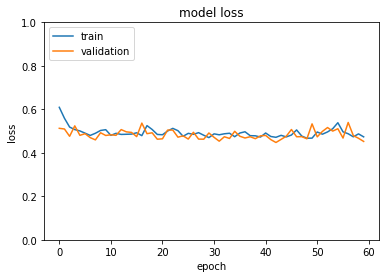

In [10]:
#accuracy的历史
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim((0, 1))
plt.show()
 
#loss的历史
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim((0, 1))
plt.show()

## 测试结果评价

In [11]:
test_y = pd.read_csv('gender_submission.csv')
test_y = np.array(test_y['Survived'])
model.evaluate(test_x,test_y)

14/14 [==============================] - 0s 3ms/step - loss: 0.2923 - binary_accuracy: 0.8900


[0.2923037111759186, 0.8899521827697754]

## 保存数据
* 保存预测生存状况
* 保存预测生存概率

In [12]:
pred = model.predict(test_x)
result = pd.DataFrame({'PassengerId':np.arange(892,892+418), 'Survived':tf.where(pred>0.5,1,0).numpy().reshape(-1)})
result.to_csv("titanic_survived_predictions.csv", index=False)

In [13]:
result = pd.DataFrame({'PassengerId':np.arange(892,892+418), 'Survived':pred.reshape(-1)})
result.to_csv("titanic_psurvived_predictions.csv", index=False)